In [1]:
##########################################################
# Loading Data and Importing Libraries
#########################################################
##########################################################
# Загрузка данных и библиотек
#########################################################

In [43]:
import pandas as pd
from datetime import datetime
import numpy as np
import re
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import silhouette_score
import kneed
from kneed import KneeLocator
import plotly.express as px
from sympy import *
import math

In [45]:
df = pd.read_csv('users_data.csv',  index_col=0)

In [46]:
df

,play_id,song_duration,song_genre,song_id,user_id,utc_play_end,utc_play_start
0,4a4d0,550.605795,DUBSTEP,f256c6af-029f-43b5-97f0-79ed6d2afc96,ed07abk8,2021-01-03T12:46:40.097000Z,2021-01-03T12:37:41.401000Z
1,z553d,441.123734,ROCK,166148d1-ad74-421c-ab58-4d1059c3c694,ke53efc9,2021-02-02T21:40:24.993000Z,2021-02-02T21:33:57.804000Z
2,f2ab0,416.181447,POP,72bb2cf2-aadf-4710-a83f-eea105fcc65e,ka417cc5,2020-12-26T19:56:54.337000Z,2020-12-26T19:50:47.469000Z
3,1c9f4,395.104341,R&B,7332a4ff-4c0c-40b9-bac6-730430b2d0d4,10dk9313,2021-01-22T03:41:08.922000Z,2021-01-22T03:34:37.926000Z
4,2b40a,786.919972,ELECTRONICS,9d40ee8c-6cb9-4b7d-9a0e-ceaf02cd8002,47e17k7a,2021-01-21T15:20:32.226000Z,2021-01-21T15:09:47.531000Z
...,...,...,...,...,...,...,...
842364,c6235,445.842668,POP,65db0eed-93a6-43eb-aca3-6d49f7d8484e,5ddf8aa0,2021-02-10T23:12:51.893000Z,2021-02-10T23:06:42.736000Z
842365,c715f,760.798642,ELECTRONICS,c15eba7a-dbde-4ea9-bc30-b734490f7ab4,fb8bab5a,2021-01-31T04:46:50.603000Z,2021-01-31T04:36:27.561000Z
842366,acf0f,427.210528,POP,751b46c5-4924-4b52-a77d-9da9e568ec89,a050bf41,2021-01-16T09:13:56.795000Z,2021-01-16T09:07:30.965000Z
842367,7c570,452.945564,VOCAL,bb71be9b-7c51-4e89-9608-c51381941d34,a95k3fa3,2021-02-28T06:18:13.383000Z,2021-02-28T06:17:14.588000Z


In [47]:
df.head()
df.dtypes
df.isnull().values.any() # there are no missing values in the dataset

False

In [48]:
################################################################
# Data Preprocessing
################################################################
################################################################
# Подготовка df для последующей работы
################################################################

In [49]:
# Convert UTC to DateTime
# Приведем все даты к DateTime формату с микросекундами
df['utc_play_end'] = pd.to_datetime(df['utc_play_end'])
df['utc_play_start'] = pd.to_datetime(df['utc_play_start'])

In [50]:
# Add 'play_duration' column - time spending on listening to song. 
# Добавим столбец 'play_duration' - время прослушивания трека. 
df['play_duration'] = [(df.utc_play_end[i] - df.utc_play_start[i]).total_seconds() for i in range(len(df)) ]
# Add 'completion' column - what share of song was listened to.
# Добавим столбец 'completion' - какую часть трека прослушал пользователь.
df['completion'] = df.play_duration/df.song_duration

In [51]:
df

,play_id,song_duration,song_genre,song_id,user_id,utc_play_end,utc_play_start,play_duration,completion
0,4a4d0,550.605795,DUBSTEP,f256c6af-029f-43b5-97f0-79ed6d2afc96,ed07abk8,2021-01-03 12:46:40.097000+00:00,2021-01-03 12:37:41.401000+00:00,538.696,0.978370
1,z553d,441.123734,ROCK,166148d1-ad74-421c-ab58-4d1059c3c694,ke53efc9,2021-02-02 21:40:24.993000+00:00,2021-02-02 21:33:57.804000+00:00,387.189,0.877733
2,f2ab0,416.181447,POP,72bb2cf2-aadf-4710-a83f-eea105fcc65e,ka417cc5,2020-12-26 19:56:54.337000+00:00,2020-12-26 19:50:47.469000+00:00,366.868,0.881510
3,1c9f4,395.104341,R&B,7332a4ff-4c0c-40b9-bac6-730430b2d0d4,10dk9313,2021-01-22 03:41:08.922000+00:00,2021-01-22 03:34:37.926000+00:00,390.996,0.989602
4,2b40a,786.919972,ELECTRONICS,9d40ee8c-6cb9-4b7d-9a0e-ceaf02cd8002,47e17k7a,2021-01-21 15:20:32.226000+00:00,2021-01-21 15:09:47.531000+00:00,644.695,0.819264
...,...,...,...,...,...,...,...,...,...
842364,c6235,445.842668,POP,65db0eed-93a6-43eb-aca3-6d49f7d8484e,5ddf8aa0,2021-02-10 23:12:51.893000+00:00,2021-02-10 23:06:42.736000+00:00,369.157,0.827998
842365,c715f,760.798642,ELECTRONICS,c15eba7a-dbde-4ea9-bc30-b734490f7ab4,fb8bab5a,2021-01-31 04:46:50.603000+00:00,2021-01-31 04:36:27.561000+00:00,623.042,0.818932
842366,acf0f,427.210528,POP,751b46c5-4924-4b52-a77d-9da9e568ec89,a050bf41,2021-01-16 09:13:56.795000+00:00,2021-01-16 09:07:30.965000+00:00,385.830,0.903138
842367,7c570,452.945564,VOCAL,bb71be9b-7c51-4e89-9608-c51381941d34,a95k3fa3,2021-02-28 06:18:13.383000+00:00,2021-02-28 06:17:14.588000+00:00,58.795,0.129806


In [52]:
# Let's check the new columns
# Gроверим новые столбцы
print(df.play_duration.describe())
df.completion.describe()

count    842369.000000
mean        425.733166
std         696.762870
min           0.005000
25%         128.326000
50%         316.266000
75%         397.081000
max        5854.082000
Name: play_duration, dtype: float64


count    842369.000000
mean          0.594901
std           0.305718
min           0.000013
25%           0.249950
50%           0.732818
75%           0.848307
max           1.273641
Name: completion, dtype: float64

In [53]:
# We may see that max value in 'completion' column > 1.
# Мы можем видеть, что максимальное значение в столбце 'completion' больше 1.
df[df.completion > 1]
# There are severeral cases with 'completion' value > 1.
# We know nothing about pauses tracking in the database. Probably, user just paused song for a short period of
#time.
# Видно, что это не единичный случай. 
# В описании данных ничего не сказано о том, как учитываются паузы. Вероятнее всего, пользователь поставил трек на паузу,
# после чего в скором времени возобновил произведение. 

,play_id,song_duration,song_genre,song_id,user_id,utc_play_end,utc_play_start,play_duration,completion
59,6aza7,423.957482,POP,5050d3a9-b428-4b86-93be-886f778f5c8c,b8f14083,2021-02-01 17:44:25.521000+00:00,2021-02-01 17:37:11.437000+00:00,434.084,1.023886
280,dz213,376.408851,POP,7588d603-74f7-44cd-bd6c-1e64cf89a887,47c0ad8b,2021-02-23 17:14:13.267000+00:00,2021-02-23 17:07:49.413000+00:00,383.854,1.019779
326,ca90d,428.627360,POP,dd7be21b-f3f8-4ac5-b851-9b18516303b4,dc3703b3,2021-02-06 21:56:24.553000+00:00,2021-02-06 21:48:32.262000+00:00,472.291,1.101869
338,1085b,370.291990,R&B,efd614e5-239a-418e-b39c-181b43719b62,3d44f9e7,2021-01-26 16:12:52.342000+00:00,2021-01-26 16:06:38.636000+00:00,373.706,1.009220
368,4a22z,515.262769,COUNTRY,655a1749-b182-459d-b9a2-1e67b252ea8d,k4ad3b9f,2021-02-27 17:34:20.069000+00:00,2021-02-27 17:25:18.242000+00:00,541.827,1.051555
...,...,...,...,...,...,...,...,...,...
841989,35a1b,454.863620,POP,9a48f670-e959-4168-9920-51ccd026a476,ceda0b4c,2021-01-03 12:21:25.673000+00:00,2021-01-03 12:13:33.955000+00:00,471.718,1.037054
841997,5az2a,508.918592,METAL,6e1a25f8-4e2b-4a57-9b3b-f22507d1a792,9e05f4ae,2021-02-18 20:49:15.558000+00:00,2021-02-18 20:40:31.831000+00:00,523.727,1.029098
842069,8703,436.094202,ROCK,d20088c6-807d-4915-a55f-13de7fdaa921,55fkd39d,2021-01-29 10:39:34.486000+00:00,2021-01-29 10:32:17.095000+00:00,437.391,1.002974
842281,47c94,452.766558,ROCK,66f85dcd-6623-4ecf-8bf0-ec040d59deef,8afdeke5,2020-12-26 09:21:57.191000+00:00,2020-12-26 09:14:23.586000+00:00,453.605,1.001852


In [54]:
# Replace values > 1 in 'completion' column with 1.
# Заменим в столбце 'completion' значения, которые больше 1, на 1
df.loc[df.completion > 1, 'completion'] = 1


In [55]:
df[df.song_genre == 'COUNTRY'].describe()

,song_duration,play_duration,completion
count,59481.000000,59481.000000,59481.000000
mean,516.566165,307.524225,0.594955
std,25.680164,158.653022,0.304794
min,441.359091,0.076000,0.000146
25%,498.628266,129.922000,0.251692
50%,517.287272,375.007000,0.733672
75%,532.763607,436.975000,0.848748
max,617.501221,664.485000,1.000000


In [56]:
# Let's check if there are users who have never listened to COUNTRY songs. 
# Проверим, есть ли слушатели, которые ни разу не слушали треки жанра 'COUNTRY'
len(df.user_id.unique()) - len(df[df.song_genre == 'COUNTRY'].user_id.unique())
# Each user has experience in listening to COUNTRY
# Каждый пользователь хотя бы раз слушал трек требуемого жанра

0

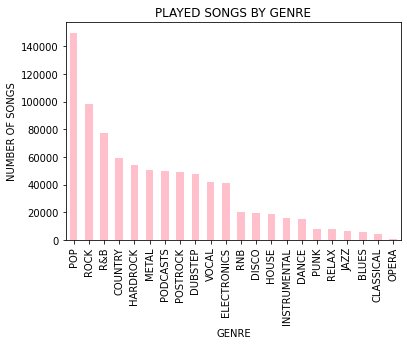

In [57]:
# Let's check the rating of COUNTRY songs among the users
# Оценим общую популярность жанра 'COUNTRY' среди аудитории
df['song_genre'].value_counts().plot(kind='bar', color = 'pink');
plt.title('PLAYED SONGS BY GENRE');
plt.xlabel('GENRE');
plt.ylabel('NUMBER OF SONGS');
# COUNTRY is in TOP-5, but not the leader. 
# COUNTRY входит в пятерку самых прослушиваемых жанров, однако сильно отстает от POP и ROCK

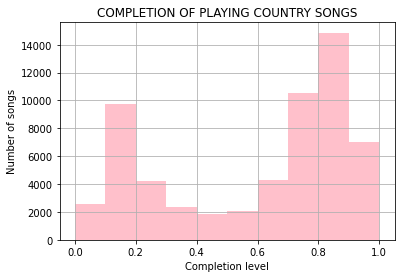

In [58]:
# Let's check how often users complete listening to COUNTRY songs
# Посмотрим на то, как часто пользователи прослушивают треки жанра техно до конца
df[df.song_genre == 'COUNTRY'].completion.hist(color = 'pink');
plt.title('COMPLETION OF PLAYING COUNTRY SONGS');
plt.xlabel('Completion level');
plt.ylabel('Number of songs');

In [59]:
# Let's find users who complete listening to COUNTRY often:
# Посмотрим, какие пользователи стабильно дослушивают 'COUNTRY'
df[(df.song_genre == 'COUNTRY') & (df.completion > 0.8)].groupby('user_id').play_id.count().sort_values()

user_id
a8b103ke     1
k9b779d3     1
dafkee0c     1
acdak034     1
10d5e9c7     1
            ..
d1dcd599    29
91cc9a98    29
e1193d31    29
9kca89fd    30
517k0k5k    31
Name: play_id, Length: 1724, dtype: int64

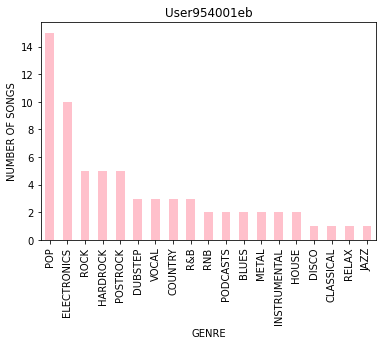

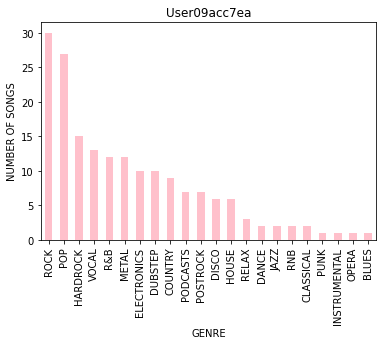

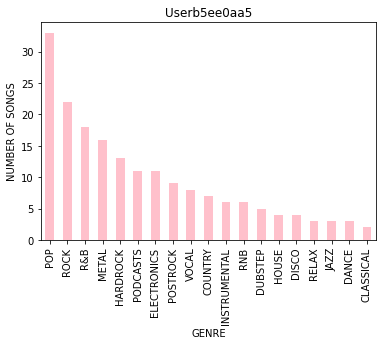

In [60]:
# 1724 out of 1727 users have experince in completing of fully listeting to COUNTRY songs
# Let's look at 3 users who don't have such an experience 
# 1724 из 1727 пользователей хотя бы раз дослушивали треки жанра 'COUNTRY' до конца
# Посмотрим на пользователей, который не входит в их число
u = df[~df.user_id.isin(df[(df.song_genre == 'COUNTRY') & (df.completion > 0.8)].user_id.unique())].user_id.unique()
for i in range(len(u)):
    #plt.figure()
    plt.title(f'User{u[i]}')
    plt.xlabel('GENRE');
    plt.ylabel('NUMBER OF SONGS');
    df[df.user_id == u[i]].song_genre.value_counts().plot(kind='bar', color = 'pink');
    plt.show()
    

In [61]:
# Let's remove those users as they are not interested in COUNTRY music
# Данных пользователей можно удалить из выборки, так как они точно не заинтересованы в жанре 'COUNTRY'
df_new = df[~df['user_id'].isin(u)].copy()
len(df.user_id.unique()) - len(df_new.user_id.unique()) == 3

True

In [62]:
# Add 'day' column
# Добавим вспомогательный столбец day
df_new['day'] = df_new['utc_play_start'].dt.date

In [63]:
df_new

,play_id,song_duration,song_genre,song_id,user_id,utc_play_end,utc_play_start,play_duration,completion,day
0,4a4d0,550.605795,DUBSTEP,f256c6af-029f-43b5-97f0-79ed6d2afc96,ed07abk8,2021-01-03 12:46:40.097000+00:00,2021-01-03 12:37:41.401000+00:00,538.696,0.978370,2021-01-03
1,z553d,441.123734,ROCK,166148d1-ad74-421c-ab58-4d1059c3c694,ke53efc9,2021-02-02 21:40:24.993000+00:00,2021-02-02 21:33:57.804000+00:00,387.189,0.877733,2021-02-02
2,f2ab0,416.181447,POP,72bb2cf2-aadf-4710-a83f-eea105fcc65e,ka417cc5,2020-12-26 19:56:54.337000+00:00,2020-12-26 19:50:47.469000+00:00,366.868,0.881510,2020-12-26
3,1c9f4,395.104341,R&B,7332a4ff-4c0c-40b9-bac6-730430b2d0d4,10dk9313,2021-01-22 03:41:08.922000+00:00,2021-01-22 03:34:37.926000+00:00,390.996,0.989602,2021-01-22
4,2b40a,786.919972,ELECTRONICS,9d40ee8c-6cb9-4b7d-9a0e-ceaf02cd8002,47e17k7a,2021-01-21 15:20:32.226000+00:00,2021-01-21 15:09:47.531000+00:00,644.695,0.819264,2021-01-21
...,...,...,...,...,...,...,...,...,...,...
842364,c6235,445.842668,POP,65db0eed-93a6-43eb-aca3-6d49f7d8484e,5ddf8aa0,2021-02-10 23:12:51.893000+00:00,2021-02-10 23:06:42.736000+00:00,369.157,0.827998,2021-02-10
842365,c715f,760.798642,ELECTRONICS,c15eba7a-dbde-4ea9-bc30-b734490f7ab4,fb8bab5a,2021-01-31 04:46:50.603000+00:00,2021-01-31 04:36:27.561000+00:00,623.042,0.818932,2021-01-31
842366,acf0f,427.210528,POP,751b46c5-4924-4b52-a77d-9da9e568ec89,a050bf41,2021-01-16 09:13:56.795000+00:00,2021-01-16 09:07:30.965000+00:00,385.830,0.903138,2021-01-16
842367,7c570,452.945564,VOCAL,bb71be9b-7c51-4e89-9608-c51381941d34,a95k3fa3,2021-02-28 06:18:13.383000+00:00,2021-02-28 06:17:14.588000+00:00,58.795,0.129806,2021-02-28


In [64]:
# Find how many days each users listened to COUNTRY 
# Найдем количество дней для каждого пользователя, когда он слушал техно.
df_new[df_new.song_genre == 'COUNTRY'].groupby('user_id').day.nunique().sort_values()

user_id
1a5b7d8a     5
ba8k13d3     5
a8b103ke     5
df5999df     5
4974aaka     7
            ..
eda3b5ab    39
179513ff    39
c8ca9850    39
357303f4    40
517k0k5k    40
Name: day, Length: 1724, dtype: int64

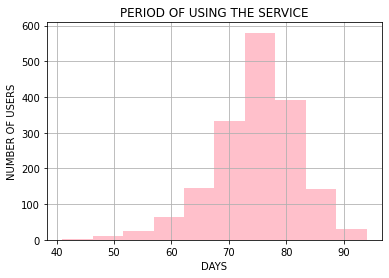

In [65]:
# The majority of users use the service for more than 2 months. 
# Большинство пользователей провели на портале более двух месяцев
df_new.groupby('user_id').day.nunique().hist(color = 'pink');
plt.title('PERIOD OF USING THE SERVICE')
plt.xlabel('DAYS');
plt.ylabel('NUMBER OF USERS');
# Almost all users spend enough for analysis time using the service.
# Практически все пользователи имеют достаточный для анализа стаж пользования услугой

In [66]:
users_list = [pd.DataFrame(df_new[df_new.song_genre == 'COUNTRY'].groupby('user_id').day.nunique()), 
            pd.DataFrame(df_new[df_new.song_genre == 'COUNTRY'].groupby(['user_id']).play_id.count()),
            pd.DataFrame(df_new[(df_new.song_genre == 'COUNTRY') & (df_new.completion > 0.8)].groupby('user_id').play_id.count())]
users = pd.concat(users_list, axis = 1)
users.columns = ['days_COUNTRY', 'COUNTRY_total_songs', 'COUNTRY_completed']

In [67]:
# Final dataset
# Финальный датасет для работы
users

,days_COUNTRY,COUNTRY_total_songs,COUNTRY_completed
user_id,,,
00001aa7,25,31,12
000b5fk1,30,52,21
00778ff1,21,26,13
007kfk8a,23,26,13
00c5e3fc,18,25,10
...,...,...,...
kk81aa11,21,32,7
kk8efd3e,28,43,14
kkbe7c5a,30,48,20


In [68]:
################################################################
# CLUSTER ANALYSIS
################################################################
################################################################
# Кластеризация
################################################################

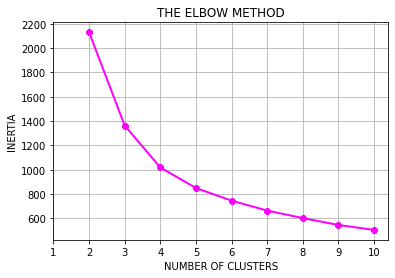

In [69]:
# There are no categorical variables in the final dataset, so we are going to use kmeans algorithm.
# Let's normalise data
# В финальном датасете нет категориальных данных, поэтому будем использовать kmeans алгоритм
# Нормализуем данные
sc = StandardScaler()
users_cl = sc.fit_transform(users)
# Find the number of clusters using The Elbow method
# Найдем число кластеров, используя The Elbow метод
inertias = []
inertias = []
for n in range(2,11):
    model = KMeans(n_clusters=n, init="k-means++", random_state=42)
    model.fit(users_cl)
    inertias.append(model.inertia_)  
plt.figure(figsize=(6,4))    
plt.grid()
plt.plot(range(2,11), inertias, linewidth=2, color="magenta", marker ="8")
plt.xlabel('NUMBER OF CLUSTERS')
plt.xticks(np.arange(1,11,1))
plt.ylabel('INERTIA')
plt.title('THE ELBOW METHOD')
plt.show()

In [70]:
kl = KneeLocator(range(2, 11), inertias, curve="convex", direction="decreasing")
print('\033[1m{:1s}\033[0m'.format('Number of clusters:'), kl.elbow)

Number of clusters: 4


In [71]:
clusters_numb = kl.elbow
model = KMeans(init = 'k-means++', 
               n_clusters = clusters_numb, 
               random_state=42)
model.fit(users_cl)

labels = model.labels_

In [72]:
users['cluster'] = labels
users.head()

,days_COUNTRY,COUNTRY_total_songs,COUNTRY_completed,cluster
user_id,,,,
00001aa7,25,31,12,0
000b5fk1,30,52,21,1
00778ff1,21,26,13,0
007kfk8a,23,26,13,0
00c5e3fc,18,25,10,0


In [73]:
users.groupby('cluster').mean()

,days_COUNTRY,COUNTRY_total_songs,COUNTRY_completed
cluster,,,
0,21.418440,29.539007,10.670213
1,32.057851,52.884298,20.772727
2,26.788136,40.205085,14.900000
3,15.262195,19.155488,6.338415


In [74]:
# Look at the clusters we got
# Рассмотрим получившиеся кластеры
for i in range(len(set(labels))):
    print('\033[1m{:1s}\033[0m'.format('Кластер ' + str(i) + ':'), users[users.cluster == i].iloc[:,0:-1].describe(), sep = '\n')

Кластер 0:
       days_COUNTRY  COUNTRY_total_songs  COUNTRY_completed
count    564.000000           564.000000         564.000000
mean      21.418440            29.539007          10.670213
std        2.206582             3.660102           2.331596
min       15.000000            22.000000           4.000000
25%       20.000000            27.000000           9.000000
50%       21.000000            29.000000          11.000000
75%       23.000000            32.000000          12.000000
max       27.000000            40.000000          17.000000
Кластер 1:
       days_COUNTRY  COUNTRY_total_songs  COUNTRY_completed
count    242.000000           242.000000         242.000000
mean      32.057851            52.884298          20.772727
std        2.878732             5.962107           3.579854
min       25.000000            41.000000          11.000000
25%       30.000000            48.000000          18.000000
50%       32.000000            52.000000          21.000000
75%       34.00000

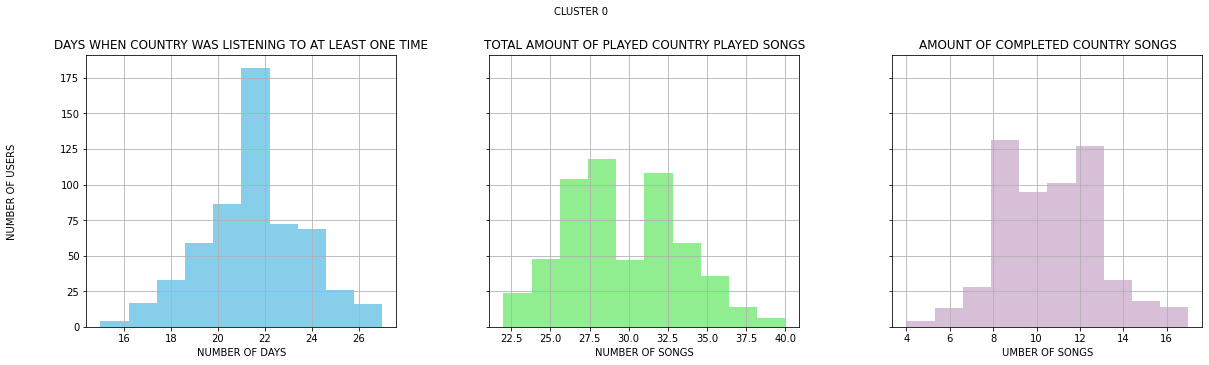

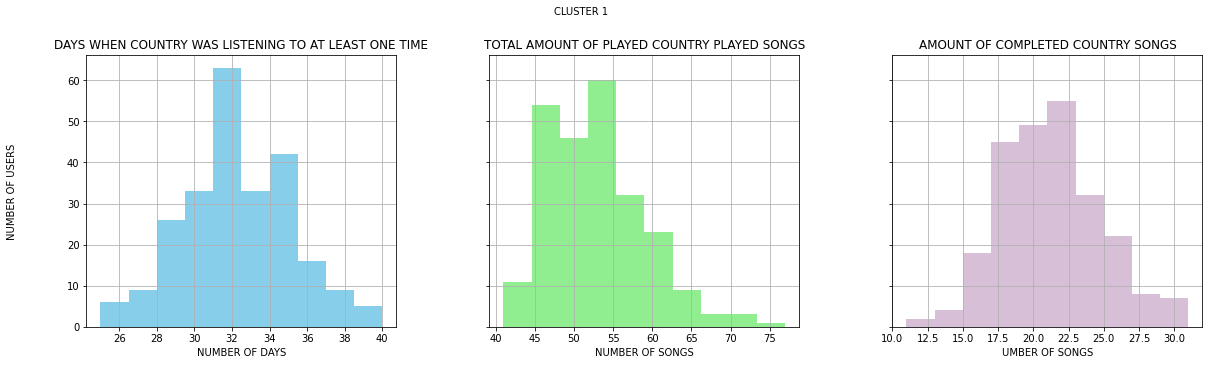

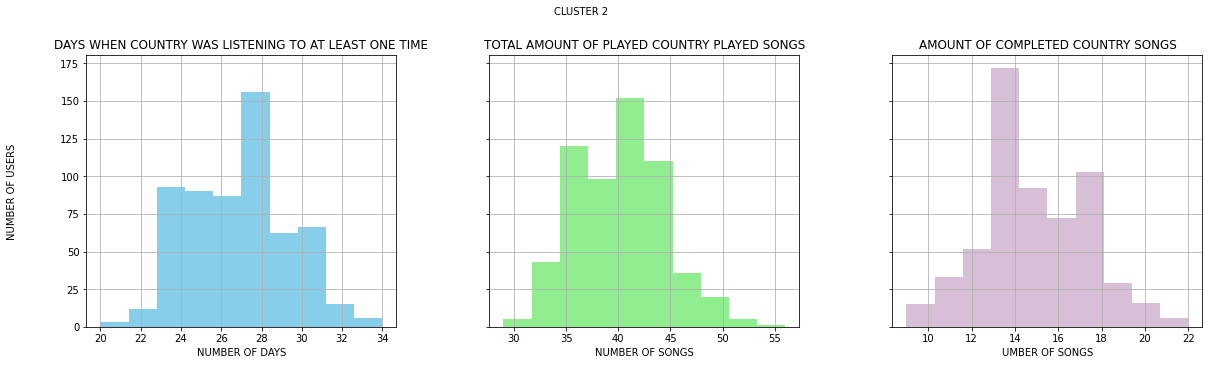

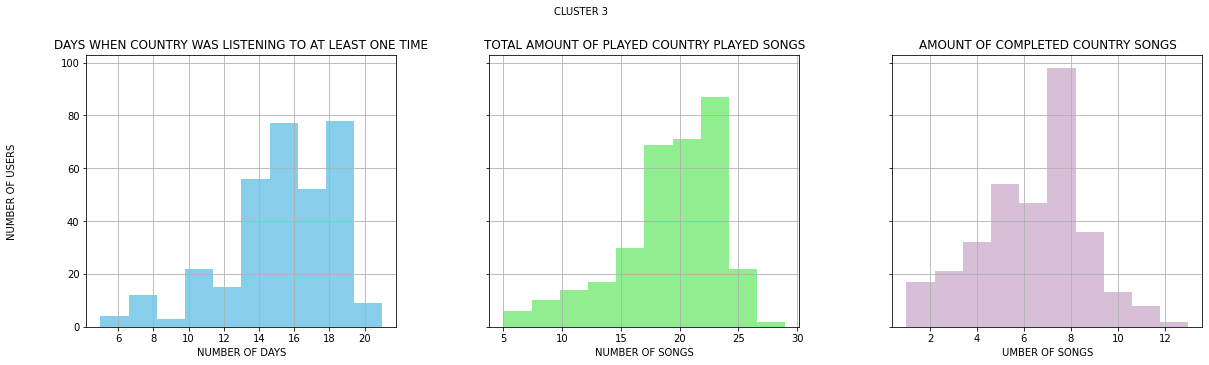

In [75]:
# Build histigram for each cluster:
# Построим гистограммы для каждого кластера:
for i in range(len(set(labels))):
    fig, ax = plt.subplots(ncols=len(users.columns[0:-1]), sharey=True, figsize=(20,5))
    fig.text(0.07, 0.5, 'NUMBER OF USERS', va='center', rotation='vertical')
    fig.text(0.45, 1, 'CLUSTER ' + str(i), va='center')
    colors = 'skyblue', 'lightgreen', 'thistle', 'lightpink'
    ax[0].set(xlabel='NUMBER OF DAYS')
    ax[1].set(xlabel='NUMBER OF SONGS')
    ax[2].set(xlabel='UMBER OF SONGS')
    for j, a, color in zip(users.columns[0:-1], ax, colors):
        users[users.cluster == i].iloc[:,:-1].hist(column =j,ax=a, color = color)
    ax[0].set_title('DAYS WHEN COUNTRY WAS LISTENING TO AT LEAST ONE TIME');
    ax[1].set_title('TOTAL AMOUNT OF PLAYED COUNTRY PLAYED SONGS');
    ax[2].set_title('AMOUNT OF COMPLETED COUNTRY SONGS');

In [76]:
# Rank the cluster using criterion 'Interest in COUNTRY music'
#Проранжируем кластеры по критерию 'Увлечение COUNTRY'
users_groups = pd.DataFrame(users.groupby('cluster').mean().rank().sum(axis =1).rank())
users_groups.columns = ['Interest in COUNTRY music']
users_groups

,Interest in COUNTRY music
cluster,
0,2.0
1,4.0
2,3.0
3,1.0


In [77]:
users.cluster.isin(users_groups['Interest in COUNTRY music'].nlargest(0 + 1).index).index

Index(['00001aa7', '000b5fk1', '00778ff1', '007kfk8a', '00c5e3fc', '00efd78b',
       '00fe8bba', '0137e0aa', '0145f791', '015f30d3',
       ...
       'kfee3431', 'kfffd39a', 'kfk77aka', 'kk08aeka', 'kk4de8k3', 'kk81aa11',
       'kk8efd3e', 'kkbe7c5a', 'kkd18130', 'kke8cefd'],
      dtype='object', name='user_id', length=1724)

In [78]:
users_groups['Interest in COUNTRY music'].nlargest(0 + 1).index

Int64Index([1], dtype='int64', name='cluster')

In [79]:
users[users.cluster.isin(users_groups['Interest in COUNTRY music'].nlargest(0 + 1).index)].index

Index(['000b5fk1', '03957fe7', '03fba4af', '07000cac', '0871b799', '08fke0a1',
       '0a0b1ada', '0a414d15', '0a4abf1f', '0ake73f7',
       ...
       'k7ab0a75', 'k8acaac0', 'k8ckb7be', 'kakf3k7b', 'kd3efab7', 'kd70c0ea',
       'ke53efc9', 'ke810d3f', 'kk4de8k3', 'kkbe7c5a'],
      dtype='object', name='user_id', length=242)

In [80]:
# Create a possible mailing lists.
# Сформируем возможные списки рассылки
# We are not going to take into account cluster with the lower rank as users into that clusters are not 
#interested in COUNTRY music at all
# Ни в один вариант не будем включать кластер с наименьшим рангом, так как пользователи, принадлежащие к данной группе, 
# наименее всех заинтересованы в COUNTRY.
# Fot the most targeting newslettes, it's reasonable to take into account cluster with the highest rank
# Если мы хотим сделать максимально таргетированную рассылку, стоит использовать кластер с максимальным рангом: 
mail_list = {'list%s' % i: [users[users.cluster.isin(users_groups['Interest in COUNTRY music'].nlargest(i + 1).index)].index] for i in range(len(users_groups) - 1)}

In [81]:
mail_list = [users[users.cluster.isin(users_groups['Interest in COUNTRY music'].nlargest(i + 1).index)].index for i in range(len(users_groups) - 1)]

In [82]:
mail_list[0]

Index(['000b5fk1', '03957fe7', '03fba4af', '07000cac', '0871b799', '08fke0a1',
       '0a0b1ada', '0a414d15', '0a4abf1f', '0ake73f7',
       ...
       'k7ab0a75', 'k8acaac0', 'k8ckb7be', 'kakf3k7b', 'kd3efab7', 'kd70c0ea',
       'ke53efc9', 'ke810d3f', 'kk4de8k3', 'kkbe7c5a'],
      dtype='object', name='user_id', length=242)

In [83]:
def ask_user():
    print('Available number of clusters:')
    for i in range(1, len(mail_list) + 1):
        print(u'\u2713', '\033[1m{:1s}\033[0m'.format(str(i)), '-', len(mail_list[i-1]), 'users')
    print('* The fewer clusters, the more the mailing list meets the criterion "User interest in COUNTRY music"')
    response = input()
    while (int(response) not in range(1, len(mail_list) + 1)):
        print('Please, choose the available number of clusters')
        response = input()
    print('Mailing list: ')
    for i in  range(1, len(mail_list) + 1):
        if (int(response) == range(1, len(mail_list) + 1)[i-1]):
            users_for_email = mail_list[i-1]
    return users_for_email
        
    

In [84]:
users_for_email = ask_user()
users_for_email

Available number of clusters:
✓ 1 - 242 users
✓ 2 - 832 users
✓ 3 - 1396 users
* The fewer clusters, the more the mailing list meets the criterion "User interest in COUNTRY music"
4
Please, choose the available number of clusters
3
Mailing list: 


Index(['00001aa7', '000b5fk1', '00778ff1', '007kfk8a', '00c5e3fc', '0137e0aa',
       '0145f791', '015f30d3', '0178d0f0', '01c79kdk',
       ...
       'kfee3431', 'kfffd39a', 'kfk77aka', 'kk08aeka', 'kk4de8k3', 'kk81aa11',
       'kk8efd3e', 'kkbe7c5a', 'kkd18130', 'kke8cefd'],
      dtype='object', name='user_id', length=1396)